# Calculate frictional slopes (part 3): The Anderson model

Copyright 2022 Marco A. Lopez-Sanchez.  
Content under [Creative Commons Attribution license CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/), code under [Mozilla Public License 2.0](https://www.mozilla.org/en-US/MPL/2.0/).

> **Goals**: Understand Anderson's model and plot our first brittle fault model

In [1]:
# import the required Python scientific libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# set a custom figure style (optional, you can comment on this whole block)
import matplotlib as mpl
mpl.style.use('fivethirtyeight')
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['axes.edgecolor'] = 'white'

## The Anderson model

Anderson (1951) proposed a model for brittle fault failure within the crust making the following assumptions:

- simplified the types of faults in three different cases (normal, inverse, and strike-slip)
- brittle fractures occur according to the Coulomb criterion
- assumed that two of the three principal stresses lies parallel to the earth's surface and the remaining one perpendicular to it (see figure below)

![](https://raw.githubusercontent.com/marcoalopez/strength_envelopes/master/figures/Anderson.jpg)

With these assumptions, Anderson recalculated the Coulomb fracture criterion in terms of differential stress $(\sigma_d = \sigma_1 - \sigma_3)$ and lithostatic stress $(\sigma_L = \rho gh)$, being the lithostatic stress for the three different cases  
- $\sigma_L = \sigma_1$ (normal),
- $\sigma_L = \sigma_3$ (inverse),
- $\sigma_L = \sigma_2$ (strike-slip).

which by rearranging give (_disclaimer: Anderson did not consider the the fuid pore pressure but here it is included_)

**Inverse fault**: $\quad \sigma_d = 2(\sigma_0+\mu \sigma_L (1 - \lambda)) / \sqrt{\mu^2 + 1}-\mu \quad (1)$

**Strike-slip fault**: $\quad \sigma_d = 2(\sigma_0+\mu \sigma_L (1 - \lambda)) / \sqrt{\mu^2 + 1} \quad (2)$

**Normal (extensional) fault**: $\quad \sigma_d = -2(\sigma_0-\mu \sigma_L (1 - \lambda)) / \sqrt{\mu^2 + 1}+\mu \quad (3)$

TODO

In [2]:
def Anderson_fault(fault_type, depths, pressure, mu=0.73, lamb=0.36, C0=0.0):
    """ Returns the corresponding differential stress in MPa for a specific depth
    based on the Anderson theory of faulting (Anderson, 1905) and the Coulomb–
    Navier’s law of friction.

    Parameters
    ----------
    fault_type : string
        the type of fault, either 'inverse', 'normal' or 'strike-slip'
    depths : array-like
        an array-like with the depths [km]
    pressure : array-like
        the lithostatic stress of pressure at different depths [GPa]
    mu : scalar between 0 and 1, optional
        Coefficient of friction. Default value 0.73; this is the Rutter
        and Glover (2012) coefficient recalculated from Byerlee (1978) data
    lamb : scalar between 0 and 1, optional
        Hubbert-Rubbey coefficient of fluid pressure. Zero is for dry conditions.
        Default = 0.36
    C0 : positive scalar, optional
        Internal cohesion of the rock [MPa]. Mostly negligible in nature, default
        is zero. Alternatively, this parameter can be used as the frictional
        cohesive strenght as well.
    """

    depths = depths * 1000  # convert km to m
    pressure = pressure * 1e9  # convert GPa to Pa

    if fault_type == 'inverse':
        diff_stress = (2 * (C0 + mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1) - mu)

    elif fault_type == 'strike-slip':
        diff_stress = (2 * (C0 + mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1))

    elif fault_type == 'normal':
        diff_stress = (- 2 * (C0 - mu * pressure * (1 - lamb))) / (np.sqrt(mu**2 + 1) + mu)
    
    else:
        raise ValueError("fault type must be 'inverse', 'strike-slip' or 'normal'")

    return diff_stress / 10**6

## First example of a frictional slope

To start simple, let's estimate at which differential stress brittle failure occurs as a function of lithostatic pressure and the type of fault. For this, let's assume that the internal cohesion of the rock is null (_Amontons' law_), that the coefficient of friction is that of the _Byerlee's law_ for low pressures $\mu = 0.85$, and that the rocks are completely dry (i.e. coefficient of fluid pressure equals 0). We also assume that the rock density and gravitational acceleration do not vary in the first 15 km of the crust.

In [3]:
# set the required parameters 
ro_crust = 2750  # average rock density in the crust [kg/m**3]
g = 9.80665      # average gravitational acceleration [m/s**2]

# generate a linear spaced array of depths every 10 m from 0 to 15 km depth
depths = np.linspace(start=0, stop=15, num=1500)

# create a spreadsheet (DataFrame) containing the depths and corresponding lithostatic stresses
data = pd.DataFrame({
    'depths': depths,
    'pressure': (ro_crust * g * depths) / 1e6})  # / 1e6 to obtain GPa
data

,depths,pressure
0,0.000000,0.000000
1,0.010007,0.000270
2,0.020013,0.000540
3,0.030020,0.000810
4,0.040027,0.001079
...,...,...
1495,14.959973,0.403445
1496,14.969980,0.403715
1497,14.979987,0.403985
1498,14.989993,0.404254


In [4]:
data['thrust'] = Anderson_fault('inverse',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)

data['normal'] = Anderson_fault('normal',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)

data['strike'] = Anderson_fault('strike-slip',
                                data['depths'],
                                data['pressure'],
                                mu=0.85,
                                lamb=0.0)
data

,depths,pressure,thrust,normal,strike
0,0.000000,0.000000,0.000000,-0.000000,0.000000
1,0.010007,0.000270,0.992056,0.212152,0.349552
2,0.020013,0.000540,1.984111,0.424305,0.699105
3,0.030020,0.000810,2.976167,0.636457,1.048657
4,0.040027,0.001079,3.968223,0.848609,1.398210
...,...,...,...,...,...
1495,14.959973,0.403445,1483.123346,317.167697,522.580854
1496,14.969980,0.403715,1484.115402,317.379849,522.930407
1497,14.979987,0.403985,1485.107457,317.592001,523.279959
1498,14.989993,0.404254,1486.099513,317.804153,523.629511


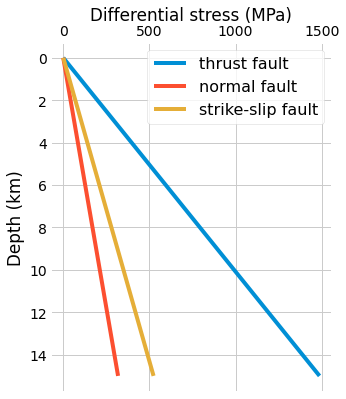

In [5]:
# initialize the plot
fig2, ax = plt.subplots(figsize=(4.5, 6))

# tweak the figure so that the depth is shown on the y-axis downwards
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')

# plot the frictional slopes
ax.plot(data['thrust'], data['depths'], label='thrust fault')
ax.plot(data['normal'], data['depths'], label='normal fault')
ax.plot(data['strike'], data['depths'], label='strike-slip fault')

ax.set(xlabel='Differential stress (MPa)', ylabel='Depth (km)')
ax.legend(loc='best', fontsize=16)

In [6]:
import sys
from datetime import date    
today = date.today().isoformat()

print(f'Notebook tested in {today} using:')
print('Python', sys.version)
print('Numpy', np.__version__)
print('Matplotlib', mpl.__version__)
print('Pandas', pd.__version__)

Notebook tested in 2022-08-23 using:
Python 3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]
Numpy 1.23.1
Matplotlib 3.5.1
Pandas 1.4.3
